# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Baseline Models

In this notebook I create the simplest models to act as a starting point that we will beat.

In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLP imports

In [3]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN} 

In [6]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [7]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:
# One more import after logging in

from items import Item

In [9]:
%matplotlib inline

# Loading the pkl files

In [10]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [11]:
# Remind ourselves the training prompt

print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [12]:
print(train[0].price)

226.95


In [13]:
# Remind a test prompt

print(test[0].test_prompt())

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $


In [14]:
#what was it supposed to fill in
print(test[0].price)

374.41


In [15]:
# The full prompt for this test sample that verifies above answer

print(test[0].prompt)

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $374.00


## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

For any function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

we can evaluate our model by calling:

`Tester.test(my_prediction_function)`

In [16]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth) #absolute error
        log_error = math.log(truth+1) - math.log(guess+1) #log error, "+1" is added when truth or guess is 0 to avoid log from blowing up
        sle = log_error ** 2 #squared log error
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size #MAE
        rmsle = math.sqrt(sum(self.sles) / self.size) #RMSLE
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

# Now for something basic

What's the very simplest model imaginable?

Let's start with a random number generator!

In [17]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $374.41 Error: $280.59 SLE: 0.31 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $115.00 Truth: $225.11 Error: $110.11 SLE: 0.45 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $26.00 Truth: $61.68 Error: $35.68 SLE: 0.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $760.00 Truth: $599.99 Error: $160.01 SLE: 0.06 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $282.00 Truth: $16.99 Error: $265.01 SLE: 7.59 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $251.00 Truth: $31.99 Error: $219.01 SLE: 4.13 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $229.00 Truth: $101.79 Error: $127.21 SLE: 0.65 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $143.00 Truth: $289.00 Error: $146.00 SLE: 0.49 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $755.00 Truth: $635.86 Error: $119.14 SLE: 0.03 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $105.00 Truth: $65.99 Error: $39.01 S

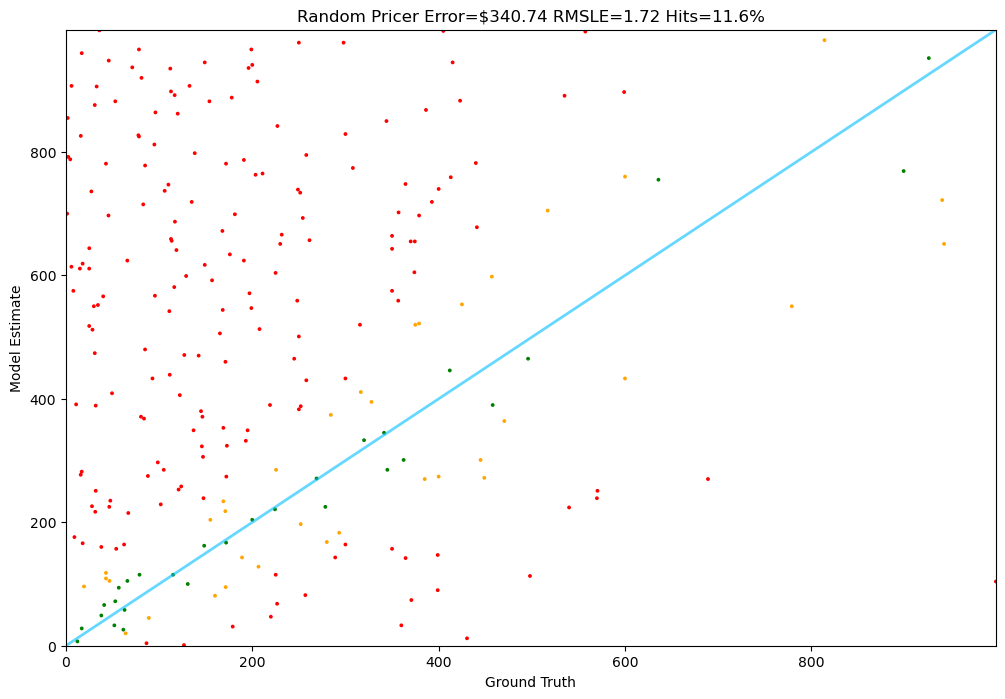

In [18]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

In [17]:
# That was fun!
# We can do better - here's another rather trivial model -> using average price

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $220.46 Truth: $374.41 Error: $153.95 SLE: 0.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $220.46 Truth: $225.11 Error: $4.65 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $220.46 Truth: $61.68 Error: $158.78 SLE: 1.59 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $220.46 Truth: $599.99 Error: $379.53 SLE: 1.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $220.46 Truth: $16.99 Error: $203.47 SLE: 6.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $220.46 Truth: $31.99 Error: $188.47 SLE: 3.63 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $220.46 Truth: $101.79 Error: $118.67 SLE: 0.59 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $220.46 Truth: $289.00 Error: $68.54 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.46 Truth: $635.86 Error: $415.40 SLE: 1.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $220.46 Truth: $65.99 Error: $154.47 S

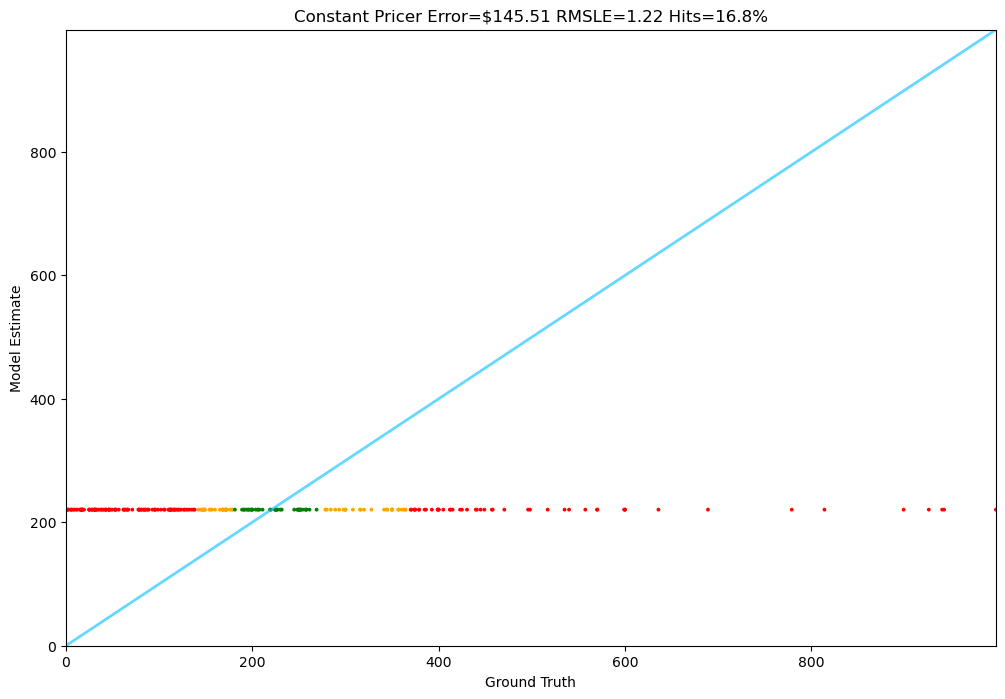

In [28]:
# Run our constant predictor
Tester.test(constant_pricer)


In [29]:
train[0].details

'{"Brand": "Delphi", "Fit Type": "Vehicle Specific Fit", "Item Dimensions LxWxH": "19.7 x 7.7 x 5.1 inches", "Item Weight": "2.2 Pounds", "Auto Part Position": "Unknown", "Operation Mode": "Mechanical", "Manufacturer": "Delphi", "Model": "FUEL PUMP", "Product Dimensions": "19.7 x 7.7 x 5.1 inches", "Country of Origin": "USA", "Item model number": "FG0166", "Is Discontinued By Manufacturer": "No", "Exterior": "Painted", "Manufacturer Part Number": "FG0166", "OEM Part Number": "25326856, 89060639, A30416, E4061R, MU242", "Best Sellers Rank": {"Automotive": 913571, "Automotive Replacement Electric Fuel Pumps": 6568}, "Domestic Shipping": "Item can be shipped within U.S.", "International Shipping": "This item is not eligible for international shipping.  Learn More", "Date First Available": "August 9, 2006"}'

In [18]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [19]:
train[0].features.keys()

dict_keys(['Brand', 'Fit Type', 'Item Dimensions LxWxH', 'Item Weight', 'Auto Part Position', 'Operation Mode', 'Manufacturer', 'Model', 'Product Dimensions', 'Country of Origin', 'Item model number', 'Is Discontinued By Manufacturer', 'Exterior', 'Manufacturer Part Number', 'OEM Part Number', 'Best Sellers Rank', 'Domestic Shipping', 'International Shipping', 'Date First Available'])

In [20]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 360062),
 ('Item Weight', 350444),
 ('Manufacturer', 349357),
 ('Brand', 340323),
 ('Best Sellers Rank', 330473),
 ('Item model number', 277573),
 ('Product Dimensions', 262400),
 ('Color', 183794),
 ('Is Discontinued By Manufacturer', 169828),
 ('Manufacturer Part Number', 145092),
 ('Material', 137447),
 ('Country of Origin', 121451),
 ('Style', 77639),
 ('Special Feature', 74709),
 ('Part Number', 74529),
 ('Batteries Required?', 73595),
 ('Package Dimensions', 72900),
 ('Item Dimensions LxWxH', 71385),
 ('Included Components', 67509),
 ('Model', 65144),
 ('Size', 58233),
 ('Item Package Quantity', 58149),
 ('Batteries Included?', 56779),
 ('OEM Part Number', 56062),
 ('Special Features', 53740),
 ('Exterior', 50566),
 ('Power Source', 50256),
 ('Vehicle Service Type', 49420),
 ('Finish Type', 46262),
 ('Voltage', 46036),
 ('Mounting Type', 38043),
 ('Model Name', 37524),
 ('Shape', 34816),
 ('Finish', 31901),
 ('Number of Items', 31871),
 ('Connectivity Te

In [21]:
for i in range(10):
    print(train[i].features.get('Item Weight'))

2.2 Pounds
81 pounds
30 pounds
None
1.15 pounds
1.44 ounces
12.3 pounds
None
116.8 pounds
156 Grams


In [22]:
#Feature Engineering
# Now some janky code to pluck out the Item Weight and transform everything into pounds

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [23]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [24]:
average_weight = sum(weights)/len(weights)
average_weight

13.57055237029551

In [25]:
#add average weight as default weight
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight 

In [26]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks) #return average rank
    return None

In [27]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

380638.258828069

In [28]:
#add average rank as default rank
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [29]:
#to capture the slight correlation of prompt length and higher price
def get_text_length(item):
    return len(item.test_prompt())

In [30]:
# investigate the brands
brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands
brands.most_common(40)

[('HP', 5500),
 ('Power Stop', 3594),
 ('Dell', 3254),
 ('Detroit Axle', 2734),
 ('Lenovo', 2441),
 ('Dorman', 2116),
 ('SAMSUNG', 1772),
 ('BUYAUTOPARTS!', 1715),
 ('ACDelco', 1609),
 ('Evan Fischer', 1415),
 ('ASUS', 1387),
 ('Sony', 1282),
 ('Canon', 1201),
 ('Callahan BRAKE PARTS', 1154),
 ('Kohler', 1152),
 ('CURT', 1120),
 ('R1 Concepts', 1054),
 ('Rareelectrical', 966),
 ('Coverking', 941),
 ('Garage-Pro', 888),
 ('Kingston Brass', 852),
 ('Spectra Premium', 834),
 ('Moen', 829),
 ('Auto Dynasty', 824),
 ('WeatherTech', 822),
 ('DELTA FAUCET', 811),
 ('Generic', 793),
 ('Apple', 783),
 ('Cardone', 765),
 ('APS', 763),
 ('K&N', 758),
 ('GM', 743),
 ('Walker', 732),
 ('EBC Brakes', 717),
 ('AKKON', 646),
 ('SPEC-D TUNING', 626),
 ('TYC', 626),
 ('Covercraft', 618),
 ('Intel', 610),
 ('A-Premium', 607)]

In [31]:
#This function returns True if the brand exists (is not None) and it matches one of the known top brands. Otherwise False.
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [32]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [33]:
# Look at features in a training item
get_features(train[0])

{'weight': 2.2,
 'rank': 460069.5,
 'text_length': 748,
 'is_top_electronics_brand': 0}

In [34]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [35]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.26423218629576695
rank: 5.197480233116637e-05
text_length: 0.007609328351322481
is_top_electronics_brand: 198.14254283207848
Intercept: 182.18661987897207
Mean Squared Error: 33034.33677196789
R-squared Score: 0.090915711948655


In [51]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $228.68 Truth: $374.41 Error: $145.73 SLE: 0.24 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $214.45 Truth: $225.11 Error: $10.66 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $191.46 Truth: $61.68 Error: $129.78 SLE: 1.26 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $389.92 Truth: $599.99 Error: $210.07 SLE: 0.18 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $211.35 Truth: $16.99 Error: $194.36 SLE: 6.09 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $211.42 Truth: $31.99 Error: $179.43 SLE: 3.47 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $190.88 Truth: $101.79 Error: $89.09 SLE: 0.39 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $190.14 Truth: $289.00 Error: $98.86 SLE: 0.17 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.89 Truth: $635.86 Error: $414.97 SLE: 1.11 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $199.88 Truth: $65.99 Error: $133.89 S

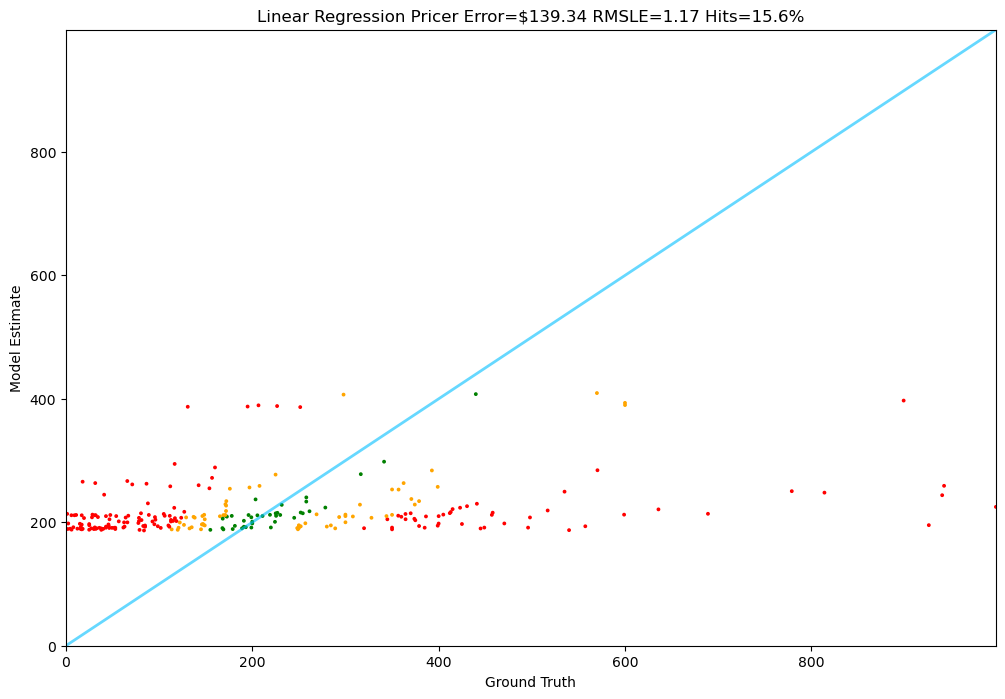

In [52]:
# test it

Tester.test(linear_regression_pricer)

In [36]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [37]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [38]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $296.58 Truth: $374.41 Error: $77.83 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $165.14 Truth: $225.11 Error: $59.97 SLE: 0.09 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $162.26 Truth: $61.68 Error: $100.58 SLE: 0.92 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $326.14 Truth: $599.99 Error: $273.85 SLE: 0.37 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $51.69 Truth: $16.99 Error: $34.70 SLE: 1.15 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $74.06 Truth: $31.99 Error: $42.07 SLE: 0.68 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $344.82 Truth: $101.79 Error: $243.03 SLE: 1.47 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $241.39 Truth: $289.00 Error: $47.61 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $404.56 Truth: $635.86 Error: $231.30 SLE: 0.20 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $111.13 Truth: $65.99 Error: $45.14 SLE: 0

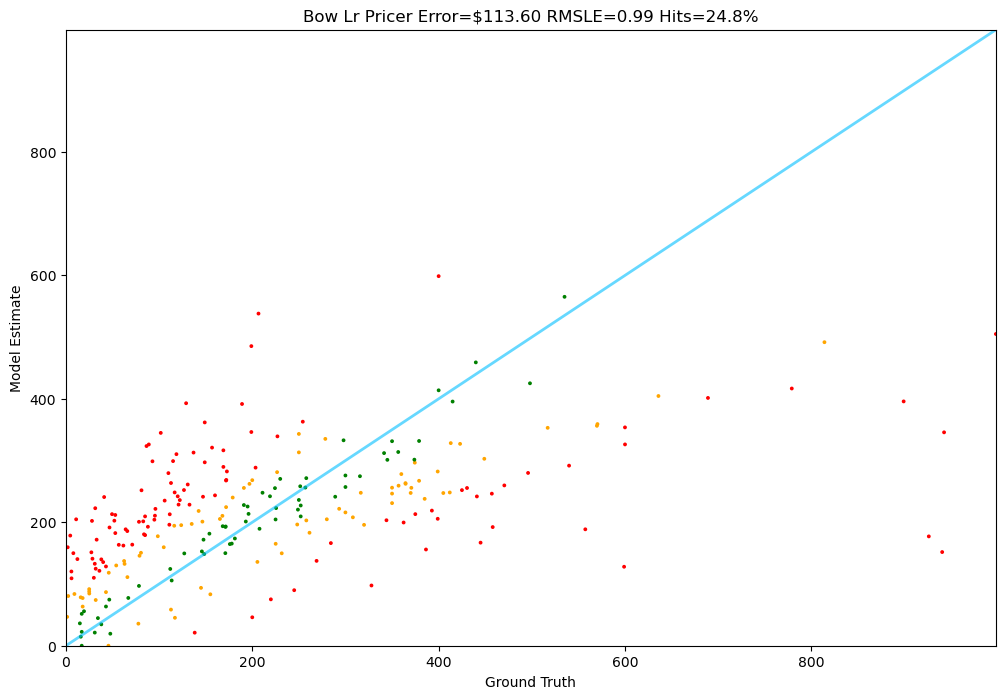

In [56]:
# test it

Tester.test(bow_lr_pricer)

In [39]:
# word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [40]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [59]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [60]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $235.42 Truth: $374.41 Error: $138.99 SLE: 0.21 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $172.77 Truth: $225.11 Error: $52.34 SLE: 0.07 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $150.41 Truth: $61.68 Error: $88.73 SLE: 0.78 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $358.52 Truth: $599.99 Error: $241.47 SLE: 0.26 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $90.41 Truth: $16.99 Error: $73.42 SLE: 2.64 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $284.04 Truth: $101.79 Error: $182.25 SLE: 1.04 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $245.20 Truth: $289.00 Error: $43.80 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $346.79 Truth: $635.86 Error: $289.07 SLE: 0.37 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $119.06 Truth: $65.99 Error: $53.07 SLE: 0

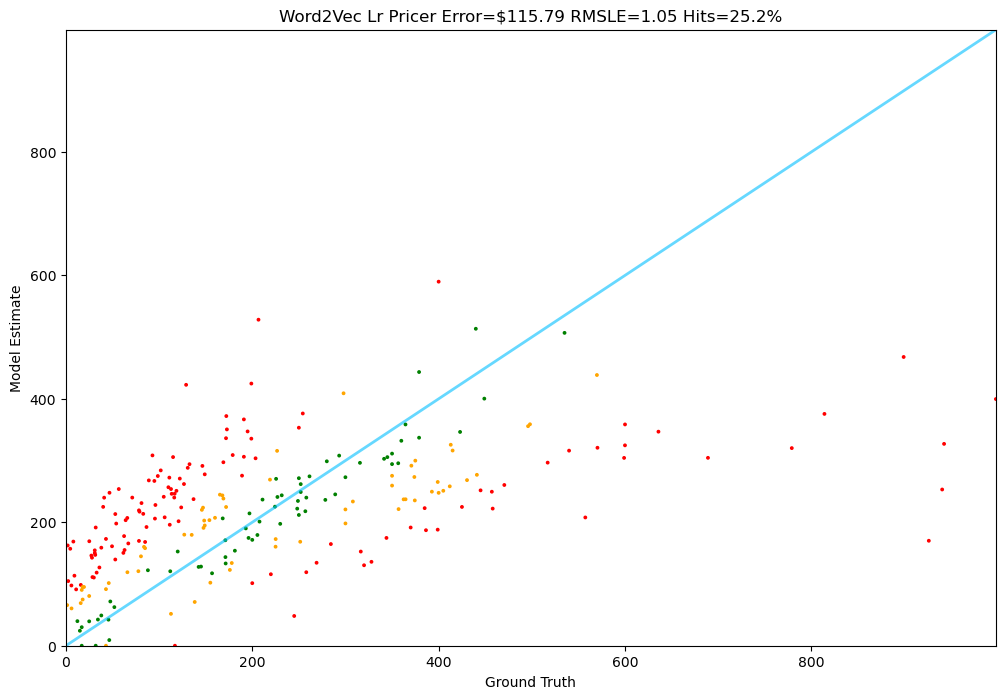

In [61]:
Tester.test(word2vec_lr_pricer)

The Price error is slightly worse than the BOW Linear Regression model and that might be because the linear regression isn't complex enough to take advantage of all the complex feature relationships with price. So, next we try some non-linear classical ML models like Support Vector Regression from Support Vector Machines and ensemble tree based regression models using Random Forest.

In [62]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


In [63]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $234.49 Truth: $374.41 Error: $139.92 SLE: 0.22 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $181.35 Truth: $225.11 Error: $43.76 SLE: 0.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $127.79 Truth: $61.68 Error: $66.11 SLE: 0.52 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $304.65 Truth: $599.99 Error: $295.34 SLE: 0.46 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $65.46 Truth: $16.99 Error: $48.47 SLE: 1.71 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $241.93 Truth: $101.79 Error: $140.14 SLE: 0.74 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $183.71 Truth: $289.00 Error: $105.29 SLE: 0.20 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $285.20 Truth: $635.86 Error: $350.66 SLE: 0.64 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $108.95 Truth: $65.99 Error: $42.96 SLE: 

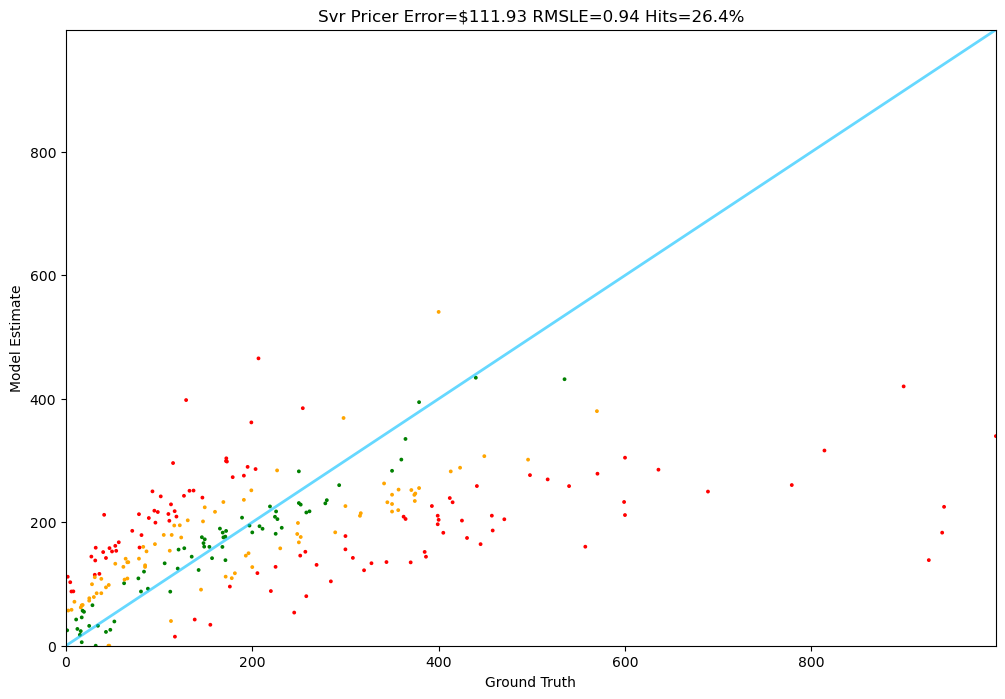

In [64]:
Tester.test(svr_pricer)

In [43]:
# And the powerful Random Forest regression, we don't tune the hyperparameters so we can develop our baseline quickly
import sys

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8,verbose=1)
rf_model.fit(X_w2v, prices)
sys.stdout.flush()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 29.6min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed: 71.9min finished


In [44]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

1: Guess: $336.57 Truth: $374.41 Error: $37.84 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $161.27 Truth: $225.11 Error: $63.84 SLE: 0.11 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $159.67 Truth: $61.68 Error: $97.99 SLE: 0.89 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $357.61 Truth: $599.99 Error: $242.38 SLE: 0.27 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $141.85 Truth: $16.99 Error: $124.86 SLE: 4.29 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $44.79 Truth: $31.99 Error: $12.80 SLE: 0.11 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $322.91 Truth: $101.79 Error: $221.12 SLE: 1.32 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $217.46 Truth: $289.00 Error: $71.54 SLE: 0.08 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $284.83 Truth: $635.86 Error: $351.03 SLE: 0.64 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $170.87 Truth: $65.99 Error: $104.88 SLE:

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

16: Guess: $379.24 Truth: $373.94 Error: $5.30 SLE: 0.00 Item: Bilstein 5100 Monotube Gas Shock Set com...
17: Guess: $348.66 Truth: $92.89 Error: $255.77 SLE: 1.73 Item: Sangean K-200 Multi-Function Upright AM/...
18: Guess: $87.38 Truth: $51.99 Error: $35.39 SLE: 0.26 Item: Charles Leonard Magnetic Lapboard Class ...
19: Guess: $270.53 Truth: $179.00 Error: $91.53 SLE: 0.17 Item: Gigabyte AMD Radeon HD 7870 2 GB GDDR5 D...
20: Guess: $56.00 Truth: $19.42 Error: $36.58 SLE: 1.05 Item: 3dRose LLC 8 x 8 x 0.25 Inches Bull Terr...
21: Guess: $446.17 Truth: $539.95 Error: $93.78 SLE: 0.04 Item: ROKINON 85mm F1.4 Auto Focus Full Frame ...
22: Guess: $151.01 Truth: $147.67 Error: $3.34 SLE: 0.00 Item: AUTOSAVER88 Headlight Assembly Compatibl...
23: Guess: $59.58 Truth: $24.99 Error: $34.59 SLE: 0.72 Item: ASI NAUTICAL 2.5 Inches Opera Glasses Bi...
24: Guess: $298.00 Truth: $149.00 Error: $149.00 SLE: 0.48 Item: Behringer TUBE OVERDRIVE TO100 Authentic...
25: Guess: $30.14 Truth: $16.99 Err

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

32: Guess: $281.68 Truth: $257.99 Error: $23.69 SLE: 0.01 Item: TCMT Passenger Backrest Sissy Bar & Lugg...
33: Guess: $243.23 Truth: $27.99 Error: $215.24 SLE: 4.54 Item: Alnicov 63.5MM Brass Tremolo Block，Tremo...
34: Guess: $228.86 Truth: $171.20 Error: $57.66 SLE: 0.08 Item: Subaru Forester Outback Legacy OEM Engin...
35: Guess: $244.72 Truth: $225.00 Error: $19.72 SLE: 0.01 Item: Richmond Auto Upholstery - 2012 Dodge Ra...
36: Guess: $173.16 Truth: $105.00 Error: $68.16 SLE: 0.25 Item: AP-39 Automotive Paint Primer Grey 2K Ur...
37: Guess: $250.75 Truth: $299.99 Error: $49.24 SLE: 0.03 Item: Road Top Wireless Carplay Retrofit Kit D...
38: Guess: $675.99 Truth: $535.09 Error: $140.90 SLE: 0.05 Item: Gibson Performance Exhaust 5658 Aluminiz...
39: Guess: $33.19 Truth: $12.33 Error: $20.86 SLE: 0.89 Item: Bella Tunno Happy Links - Baby Montessor...
40: Guess: $260.02 Truth: $84.99 Error: $175.03 SLE: 1.23 Item: CANMORE H300 Handheld GPS Golf Device, S...
41: Guess: $94.90 Truth: $15.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

48: Guess: $238.75 Truth: $224.35 Error: $14.40 SLE: 0.00 Item: Universal Air Conditioner KT 1031 A/C Co...
49: Guess: $444.66 Truth: $814.00 Error: $369.34 SLE: 0.36 Item: Street Series Stainless Performance Cat-...
50: Guess: $490.36 Truth: $439.88 Error: $50.48 SLE: 0.01 Item: Lenovo IdeaPad 3 14-inch Laptop, 14.0-in...
51: Guess: $404.75 Truth: $341.43 Error: $63.32 SLE: 0.03 Item: Access Bed Covers TonnoSport 22050219 - ...
52: Guess: $196.21 Truth: $46.78 Error: $149.43 SLE: 2.01 Item: G.I. JOE Hasbro 3 3/4" Wave 5 Action Fig...
53: Guess: $227.00 Truth: $171.44 Error: $55.56 SLE: 0.08 Item: T&S Brass B-0232-BST Double Pantry Fauce...
54: Guess: $190.18 Truth: $458.00 Error: $267.82 SLE: 0.77 Item: ZTUOAUMA Fuel Injection Pump 3090942 309...
55: Guess: $216.88 Truth: $130.75 Error: $86.13 SLE: 0.25 Item: 2AP18AA#ABA Hp Prime Graphing Calculator...
56: Guess: $147.18 Truth: $83.81 Error: $63.37 SLE: 0.31 Item: Lowrance 000-0119-83 Nmea 2000 25' Exten...
57: Guess: $167.30 Truth: $

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

63: Guess: $309.69 Truth: $364.41 Error: $54.72 SLE: 0.03 Item: Wilwood Engineering 14011291R Brake Cali...
64: Guess: $149.23 Truth: $127.03 Error: $22.20 SLE: 0.03 Item: ACDelco Gold 336-1925A Starter, Remanufa...
65: Guess: $691.95 Truth: $778.95 Error: $87.00 SLE: 0.01 Item: UWS EC10783 69-Inch Matte Black Heavy-Wa...
66: Guess: $459.94 Truth: $206.66 Error: $253.28 SLE: 0.64 Item: Dell Latitude E5440 14in Business Laptop...
67: Guess: $148.31 Truth: $35.94 Error: $112.37 SLE: 1.95 Item: (Plug and Play) Spare Tire Brake Light W...
68: Guess: $248.37 Truth: $149.00 Error: $99.37 SLE: 0.26 Item: The Ultimate Roadside Rescue Assistant
69: Guess: $245.36 Truth: $251.98 Error: $6.62 SLE: 0.00 Item: Brand New 18" x 8.5" Replacement Wheel f...
70: Guess: $207.52 Truth: $160.00 Error: $47.52 SLE: 0.07 Item: Headlight Headlamp LH Left & RH Right Pa...
71: Guess: $148.26 Truth: $39.99 Error: $108.27 SLE: 1.67 Item: Lilo And Stitch Deluxe Oversize Print La...
72: Guess: $268.63 Truth: $362.41

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

78: Guess: $167.75 Truth: $146.48 Error: $21.27 SLE: 0.02 Item: Max Advanced Brakes Elite XDS Front Cros...
79: Guess: $176.21 Truth: $156.83 Error: $19.38 SLE: 0.01 Item: Quality-Built 11030 Premium Quality Alte...
80: Guess: $280.62 Truth: $251.99 Error: $28.63 SLE: 0.01 Item: Lucida LG-510 Student Classical Guitar, ...
81: Guess: $221.54 Truth: $940.33 Error: $718.79 SLE: 2.08 Item: Longacre 52-79800 Aluminum Turn Plates
82: Guess: $190.95 Truth: $52.99 Error: $137.96 SLE: 1.61 Item: Motion Pro 08-0380 Adjustable Torque Wre...
83: Guess: $143.37 Truth: $219.95 Error: $76.58 SLE: 0.18 Item: Glyph Thunderbolt 3 NVMe Dock (0 GB)
84: Guess: $313.66 Truth: $441.03 Error: $127.37 SLE: 0.12 Item: TOYO Open Country MT Performance Radial ...
85: Guess: $274.40 Truth: $168.98 Error: $105.42 SLE: 0.23 Item: Razer Seiren X USB Streaming Microphone ...
86: Guess: $69.78 Truth: $2.49 Error: $67.29 SLE: 9.06 Item: Happy Birthday to Dad From Your Daughter...
87: Guess: $295.07 Truth: $98.62 Error: 

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

93: Guess: $254.30 Truth: $219.00 Error: $35.30 SLE: 0.02 Item: Fieldpiece JL2 Job Link Wireless App Tra...
94: Guess: $290.67 Truth: $225.55 Error: $65.12 SLE: 0.06 Item: hansgrohe Talis S Modern Premium Easy Cl...
95: Guess: $287.98 Truth: $495.95 Error: $207.97 SLE: 0.29 Item: G-Technology G-SPEED eS PRO High-Perform...
96: Guess: $767.20 Truth: $942.37 Error: $175.17 SLE: 0.04 Item: DreamLine SHDR-1960723L-01 Shower Door, ...
97: Guess: $229.68 Truth: $1.94 Error: $227.74 SLE: 19.03 Item: Sanctuary Square Backplate Finish: Oiled...
98: Guess: $278.44 Truth: $284.34 Error: $5.90 SLE: 0.00 Item: Pelican Protector 1750 Long Case - Multi...
99: Guess: $211.06 Truth: $171.90 Error: $39.16 SLE: 0.04 Item: Brock Replacement Driver and Passenger H...
100: Guess: $129.52 Truth: $144.99 Error: $15.47 SLE: 0.01 Item: Carlinkit Ai Box Mini, Android 11, Multi...
101: Guess: $262.57 Truth: $470.47 Error: $207.90 SLE: 0.34 Item: StarDot NetCamLIVE2 YouTube Live Stream ...
102: Guess: $278.81 Trut

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

109: Guess: $375.58 Truth: $370.71 Error: $4.87 SLE: 0.00 Item: Set 2 Heavy Duty 12-16.5 12x16.5 12 Ply ...
110: Guess: $123.82 Truth: $65.88 Error: $57.94 SLE: 0.39 Item: Hairpin Table Legs 28" Heavy Duty Hairpi...
111: Guess: $190.61 Truth: $229.99 Error: $39.38 SLE: 0.03 Item: Marada Racing Seat with Adjustable Slide...
112: Guess: $129.38 Truth: $9.14 Error: $120.24 SLE: 6.52 Item: Remington Industries 24UL1007STRWHI25 24...
113: Guess: $531.72 Truth: $199.00 Error: $332.72 SLE: 0.96 Item: Acer S3-391-6046 13.3-inch Ultrabook, In...
114: Guess: $258.98 Truth: $109.99 Error: $148.99 SLE: 0.72 Item: ICBEAMER 7" RGB LED Headlights Bulb Halo...
115: Guess: $371.33 Truth: $570.42 Error: $199.09 SLE: 0.18 Item: R1 Concepts Front Rear Brakes and Rotors...
116: Guess: $294.77 Truth: $279.99 Error: $14.78 SLE: 0.00 Item: Camplux 2.64 GPM Tankless , Outdoor Port...
117: Guess: $65.65 Truth: $30.99 Error: $34.66 SLE: 0.54 Item: KNOKLOCK 10 Pack 3.75 Inch(96mm) Kitchen...
118: Guess: $206.68 T

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

125: Guess: $292.79 Truth: $356.99 Error: $64.20 SLE: 0.04 Item: Covercraft Carhartt SeatSaver Front Row ...
126: Guess: $160.23 Truth: $319.95 Error: $159.72 SLE: 0.47 Item: Sennheiser SD Pro 2 (506008) - Double-Si...
127: Guess: $151.20 Truth: $96.06 Error: $55.14 SLE: 0.20 Item: Hitachi MAF0110 Mass Air Flow Sensor
128: Guess: $268.56 Truth: $190.99 Error: $77.57 SLE: 0.12 Item: AmScope SE305R-P-LED-PS36A 10X-30X LED C...
129: Guess: $206.84 Truth: $257.95 Error: $51.11 SLE: 0.05 Item: Front Left Driver Side Window Regulator ...
130: Guess: $200.51 Truth: $62.95 Error: $137.56 SLE: 1.32 Item: Premium Replica Hubcap Set, Fits Nissan ...
131: Guess: $58.40 Truth: $47.66 Error: $10.74 SLE: 0.04 Item: Excellerations Phonics Spelling Game for...
132: Guess: $317.62 Truth: $226.99 Error: $90.63 SLE: 0.11 Item: RC4WD BigDog Dual Axle Scale Car/Truck T...
133: Guess: $344.13 Truth: $359.95 Error: $15.82 SLE: 0.00 Item: Unknown Stage 2 Clutch Kit - Low Altitud...
134: Guess: $231.47 Truth: $

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

141: Guess: $191.13 Truth: $78.40 Error: $112.73 SLE: 0.78 Item: B&M 30287 Throttle Valve/Kickdown Cable,...
142: Guess: $128.54 Truth: $116.25 Error: $12.29 SLE: 0.01 Item: Gates TCK226 PowerGrip Premium Timing Be...
143: Guess: $122.12 Truth: $112.78 Error: $9.34 SLE: 0.01 Item: Monroe Shocks & Struts Quick-Strut 17149...
144: Guess: $74.85 Truth: $27.32 Error: $47.53 SLE: 0.97 Item: Feit Electric BPMR16/GU10/930CA/6 35W EQ...
145: Guess: $115.98 Truth: $145.91 Error: $29.93 SLE: 0.05 Item: Yellow Jacket 2806 Contractor Extension ...
146: Guess: $216.96 Truth: $171.09 Error: $45.87 SLE: 0.06 Item: Garage-Pro Tailgate SET Compatible with ...
147: Guess: $156.47 Truth: $167.95 Error: $11.48 SLE: 0.00 Item: 3M Perfect It Buffing and Polishing Kit ...
148: Guess: $70.70 Truth: $28.49 Error: $42.21 SLE: 0.79 Item: Chinese Style Dollhouse Model DIY Miniat...
149: Guess: $188.42 Truth: $122.23 Error: $66.19 SLE: 0.18 Item: Generic NRG Innovations SRK-161H Steerin...
150: Guess: $88.90 Truth

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

156: Guess: $193.34 Truth: $189.00 Error: $4.34 SLE: 0.00 Item: NikoMaku Mirror Dash Cam Front and Rear ...
157: Guess: $141.16 Truth: $120.91 Error: $20.25 SLE: 0.02 Item: Fenix HP25R v2.0 USB-C Rechargeable Head...
158: Guess: $221.44 Truth: $203.53 Error: $17.91 SLE: 0.01 Item: R&L Racing Heavy Duty Roll-Up Soft Tonne...
159: Guess: $361.86 Truth: $349.99 Error: $11.87 SLE: 0.00 Item: Garmin 010-02258-10 GPSMAP 64sx, Handhel...
160: Guess: $84.88 Truth: $34.35 Error: $50.53 SLE: 0.79 Item: Brown 5-7/8" X 8-1/2" X 3/16" Thick Heav...
161: Guess: $257.44 Truth: $384.99 Error: $127.55 SLE: 0.16 Item: GAOMON PD2200 Pen Display & 20 Pen Nibs ...
162: Guess: $243.09 Truth: $211.00 Error: $32.09 SLE: 0.02 Item: VXMOTOR for 97-03 Ford F150/F250 Lightdu...
163: Guess: $459.27 Truth: $129.00 Error: $330.27 SLE: 1.60 Item: HP EliteBook 2540p Intel Core i7-640LM X...
164: Guess: $193.08 Truth: $111.45 Error: $81.63 SLE: 0.30 Item: Green EPX Mixing Nozzles 100-Pack-fits 3...
165: Guess: $167.41 

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

172: Guess: $170.63 Truth: $165.28 Error: $5.35 SLE: 0.00 Item: Cardone 78-4226 Remanufactured Ford Comp...
173: Guess: $181.88 Truth: $56.74 Error: $125.14 SLE: 1.33 Item: Kidde AccessPoint 001798 Supra TouchPoin...
174: Guess: $202.24 Truth: $307.95 Error: $105.71 SLE: 0.18 Item: 3M Protecta 3100414 Self Retracting Life...
175: Guess: $187.36 Truth: $38.00 Error: $149.36 SLE: 2.48 Item: Plantronics 89435-01 Wired Headset, Blac...
176: Guess: $190.93 Truth: $53.00 Error: $137.93 SLE: 1.61 Item: Logitech K750 Wireless Solar Keyboard fo...
177: Guess: $362.07 Truth: $498.00 Error: $135.93 SLE: 0.10 Item: Olympus PEN E-PL9 Body Only with 3-Inch ...
178: Guess: $211.66 Truth: $53.99 Error: $157.67 SLE: 1.83 Item: Beck/Arnley 051-6066 Hub & Bearing Assem...
179: Guess: $303.59 Truth: $350.00 Error: $46.41 SLE: 0.02 Item: Eibach Pro-Kit Performance Springs E10-6...
180: Guess: $174.02 Truth: $299.95 Error: $125.93 SLE: 0.29 Item: LEGO DC Batman 1989 Batwing 76161 Displa...
181: Guess: $174.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

188: Guess: $15.10 Truth: $14.99 Error: $0.11 SLE: 0.00 Item: Arepa - Venezuelan cuisine - Venezuela P...
189: Guess: $168.55 Truth: $84.95 Error: $83.60 SLE: 0.46 Item: Schlage Lock Company KS23D2300 Padlock, ...
190: Guess: $188.77 Truth: $111.00 Error: $77.77 SLE: 0.28 Item: Techni Mobili White Sit to Stand Mobile ...
191: Guess: $166.66 Truth: $123.73 Error: $42.93 SLE: 0.09 Item: Special Lite Products Contemporary Wall ...
192: Guess: $267.89 Truth: $557.38 Error: $289.49 SLE: 0.53 Item: Tascam DP-24SD 24-Track Digital Portastu...
193: Guess: $190.26 Truth: $95.55 Error: $94.71 SLE: 0.47 Item: Glow Lighting 636CC10SP Vista Crystal Fl...
194: Guess: $208.26 Truth: $154.00 Error: $54.26 SLE: 0.09 Item: Z3 Wind Deflector, Smoke Tint, Lexan, Wi...
195: Guess: $320.65 Truth: $198.99 Error: $121.66 SLE: 0.23 Item: Olympus E-20 5MP Digital Camera w/ 4x Op...
196: Guess: $195.49 Truth: $430.44 Error: $234.95 SLE: 0.62 Item: PHYNEDI 1:1000 World Trade Center (1973-...
197: Guess: $135.26 T

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

204: Guess: $381.37 Truth: $399.99 Error: $18.62 SLE: 0.00 Item: Franklin Iron Works Sperry Industrial Br...
205: Guess: $66.60 Truth: $4.66 Error: $61.94 SLE: 6.15 Item: Avery Legal Dividers, Standard Collated ...
206: Guess: $269.05 Truth: $261.41 Error: $7.64 SLE: 0.00 Item: Moen 8346 Commercial Posi-Temp Pressure ...
207: Guess: $239.13 Truth: $136.97 Error: $102.16 SLE: 0.31 Item: Carlisle Versa Trail ATR All Terrain Rad...
208: Guess: $191.55 Truth: $79.00 Error: $112.55 SLE: 0.77 Item: SUNWAYFOTO 44mm Tripod Ball Head Arca Co...
209: Guess: $246.81 Truth: $444.99 Error: $198.18 SLE: 0.35 Item: NanoBeam AC NBE-5AC-Gen2-US 4 Units 5GHz...
210: Guess: $239.07 Truth: $411.94 Error: $172.87 SLE: 0.29 Item: WULF 4" Front 2" Rear Leveling Lift Kit ...
211: Guess: $290.85 Truth: $148.40 Error: $142.45 SLE: 0.45 Item: Alera ALEVABFMC Valencia Series Mobile B...
212: Guess: $119.76 Truth: $244.99 Error: $125.23 SLE: 0.51 Item: YU-GI-OH! Ignition Assault Booster Box
213: Guess: $191.21 Tru

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

219: Guess: $283.04 Truth: $404.99 Error: $121.95 SLE: 0.13 Item: FixtureDisplays® Metal Truss Podium Doub...
220: Guess: $263.19 Truth: $207.76 Error: $55.43 SLE: 0.06 Item: ACDelco 13597235 GM Original Equipment A...
221: Guess: $189.46 Truth: $171.82 Error: $17.64 SLE: 0.01 Item: EBC S1KF1135 Stage-1 Premium Street Brak...
222: Guess: $313.55 Truth: $293.24 Error: $20.31 SLE: 0.00 Item: FXR Men's Boost FX Jacket (Black/Orange/...
223: Guess: $259.06 Truth: $374.95 Error: $115.89 SLE: 0.14 Item: SuperATV Scratch Resistant 3-in-1 Flip W...
224: Guess: $127.43 Truth: $111.99 Error: $15.44 SLE: 0.02 Item: SBU 3 Layer All Weather Mini Van Car Cov...
225: Guess: $27.02 Truth: $42.99 Error: $15.97 SLE: 0.20 Item: 2 Pack Outdoor Brochure Holder Advertisi...
226: Guess: $125.04 Truth: $116.71 Error: $8.33 SLE: 0.00 Item: Monroe Shocks & Struts Quick-Strut 17158...
227: Guess: $179.69 Truth: $118.61 Error: $61.08 SLE: 0.17 Item: Elements of Design Magellan EB235AL Thre...
228: Guess: $181.83 

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

235: Guess: $266.62 Truth: $249.99 Error: $16.63 SLE: 0.00 Item: Bostingner Shower Faucets Sets Complete,...
236: Guess: $200.75 Truth: $42.99 Error: $157.76 SLE: 2.32 Item: PIT66 Front Bumper Turn Signal Lights, C...
237: Guess: $34.16 Truth: $17.99 Error: $16.17 SLE: 0.38 Item: Caseology Bumpy Compatible with Google P...
238: Guess: $329.26 Truth: $425.00 Error: $95.74 SLE: 0.06 Item: Fleck 2510 Timer Mechanical Filter Contr...
239: Guess: $271.24 Truth: $249.99 Error: $21.25 SLE: 0.01 Item: Haloview MC7108 Wireless RV Backup Camer...
240: Guess: $118.33 Truth: $138.23 Error: $19.90 SLE: 0.02 Item: Schmidt Spiele - Manhattan
241: Guess: $281.00 Truth: $414.99 Error: $133.99 SLE: 0.15 Item: Corsa 14333 Tip Kit (Ford Mustang GT)
242: Guess: $218.45 Truth: $168.28 Error: $50.17 SLE: 0.07 Item: Hoshizaki FM116A Fan Motor Kit 1
243: Guess: $182.86 Truth: $199.99 Error: $17.13 SLE: 0.01 Item: BAINUO Antler Chandelier Lighting,6 Ligh...
244: Guess: $224.42 Truth: $126.70 Error: $97.72 SLE: 

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

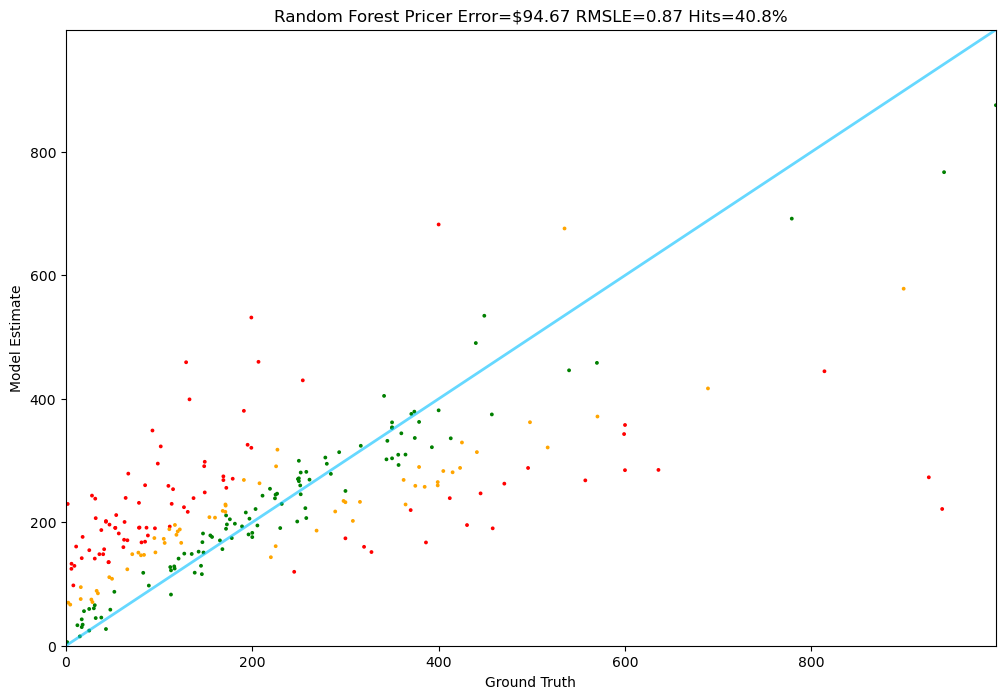

In [45]:
Tester.test(random_forest_pricer)

# Conclusion

## RF performed the best by a large margin!

## RF Avg Price Error is $94.67, RMSLE is 0.87, and It got 40.8% prices about right.